<a href="https://colab.research.google.com/github/vahedshaik/cmpe258_neural_networks/blob/main/Asst3_part_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary libraries
import jax
from jax import numpy as jnp
from jax import grad, value_and_grad
from jax.example_libraries import stax, optimizers

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Generate non-linear data and initialize weights and bias
n = 1000
dim = 3
x = np.random.uniform(-1, 1, (n, dim))
print('Input shape =', x.shape)
weights = np.array([[2, -3.5, 7]]).T
bias = np.array([8])
print('Weights shape =', weights.shape)
print('Bias shape =', bias.shape)
y_true = np.einsum('ij, jk -> ik', (x**3),  weights) + np.einsum('ij, jk -> ik', (x**2),  weights) + np.einsum('ij, jk -> ik', x, weights) + bias
print('Function output shape =', y_true.shape)

Input shape = (1000, 3)
Weights shape = (3, 1)
Bias shape = (1,)
Function output shape = (1000, 1)


In [ ]:
input_dim = dim
output_dim = 1
hidden_dim = 32

learning_rate = 0.01
num_epochs = 100

seed = jax.random.PRNGKey(101)

In [ ]:
#Using low-level API
def initialize_weights(input_dim, output_dim, hidden_dim, seed):
  weights = []
  w = jax.random.uniform(key=seed, shape=(input_dim, hidden_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(hidden_dim,), dtype=jnp.float32)
  weights.append([w,b])
  w = jax.random.uniform(key=seed, shape=(hidden_dim, hidden_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(hidden_dim,), dtype=jnp.float32)
  weights.append([w,b])
  w = jax.random.uniform(key=seed, shape=(hidden_dim, output_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(output_dim,), dtype=jnp.float32)
  weights.append([w,b])

  return weights

In [ ]:
# Non-linear activation function

def relu(x):
  return jnp.maximum(x, jnp.zeros_like(x))

In [ ]:
def linear(weights, input, activation=lambda x: x):
  weights, bias = weights
  out = jnp.dot(input, weights) + bias
  return activation(out)

In [ ]:
def forward(weights, input):
  layer_out = input

  for i in range(len(weights[:-1])):
    layer_out = linear(weights[i], layer_out, relu)

  preds = linear(weights[-1], layer_out)

  return preds.squeeze()

In [ ]:
def mean_squared_error(weights, input, actual):
    preds = forward(weights, input)
    return jnp.power(actual - preds, 2).mean()

In [ ]:
def backward(weights, input, actual):
    loss = grad(mean_squared_error)
    gradients = loss(weights, input, actual)
    return gradients

In [ ]:
# Train network and Update Weights
def train(weights, x, y_true, learning_rate, num_epochs):
  loss_ =  []
  for epoch in range(num_epochs):
    loss_value = mean_squared_error(weights, x, y_true)
    gradients = backward(weights, x, y_true)
    for j in range(len(weights)):
      weights[j][0] -= learning_rate * gradients[j][0] 
      weights[j][1] -= learning_rate * gradients[j][1]
    print(f'Epoch {epoch}, loss {loss_value}')
    loss_.append(loss_value)
  return loss_

In [ ]:
# Initialize weights and Train model
weights = initialize_weights(input_dim, output_dim, hidden_dim, seed)
loss_ = train(weights, x, y_true, learning_rate, num_epochs)

Epoch 0, loss 92.53471374511719
Epoch 1, loss 329.47869873046875
Epoch 2, loss 595.0638427734375
Epoch 3, loss 166.96487426757812
Epoch 4, loss 146.96929931640625
Epoch 5, loss 130.37429809570312
Epoch 6, loss 111.42737579345703
Epoch 7, loss 90.13272094726562
Epoch 8, loss 73.64562225341797
Epoch 9, loss 67.3382339477539
Epoch 10, loss 66.56302642822266
Epoch 11, loss 66.47395324707031
Epoch 12, loss 66.419189453125
Epoch 13, loss 66.3797607421875
Epoch 14, loss 66.35035705566406
Epoch 15, loss 66.327880859375
Epoch 16, loss 66.31004333496094
Epoch 17, loss 66.29550170898438
Epoch 18, loss 66.28321075439453
Epoch 19, loss 66.27255249023438
Epoch 20, loss 66.26313018798828
Epoch 21, loss 66.25458526611328
Epoch 22, loss 66.2468490600586
Epoch 23, loss 66.23971557617188
Epoch 24, loss 66.23310852050781
Epoch 25, loss 66.22701263427734
Epoch 26, loss 66.22124481201172
Epoch 27, loss 66.21585083007812
Epoch 28, loss 66.21078491210938
Epoch 29, loss 66.20597839355469
Epoch 30, loss 66.2014

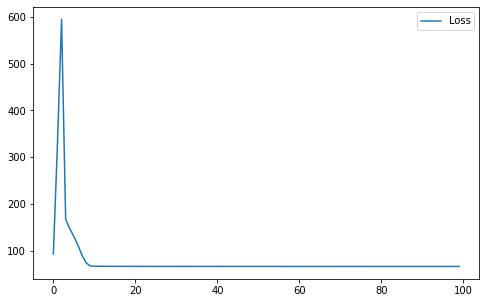

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_, label='Loss')
plt.legend()

In [ ]:
#Using high-level API
init, apply = stax.serial(stax.Dense(input_dim),
                          stax.Relu,
                          stax.Dense(hidden_dim),
                          stax.Relu,
                          stax.Dense(hidden_dim),
                          stax.Relu,
                          stax.Dense(output_dim),
                          )

In [ ]:
def mean_squared_error(weights, input, y_true):
    y_pred = apply(weights, input).squeeze()
    return jnp.power(y_true - y_pred, 2).mean()

In [ ]:
# Training neural netwrok method and updating weights

def train(x, y_true, num_epochs, opt_state):
  loss_ = []

  for epoch in range(num_epochs):
    loss_value, gradients = value_and_grad(mean_squared_error)(optimizer_get_weights(opt_state), x, y_true)
    opt_state = optimizer_update(epoch, gradients, opt_state)

    loss_.append(loss_value)
    print(f'Epoch {epoch}, loss {loss_value}')

  return opt_state, loss_

In [ ]:
# Initialize weights by passing input dimensions to init function 

weights = init(seed, (x.shape[1],))
weights = weights[1]

optimizer_init, optimizer_update, optimizer_get_weights = optimizers.sgd(learning_rate)
optimizer_state = optimizer_init(weights)

final_optimizer_state, loss_ = train(x, y_true, num_epochs, optimizer_state)

Epoch 0, loss 172.29136657714844
Epoch 1, loss 164.39207458496094
Epoch 2, loss 157.0961151123047
Epoch 3, loss 148.2129364013672
Epoch 4, loss 137.0707244873047
Epoch 5, loss 122.83320617675781
Epoch 6, loss 104.67330932617188
Epoch 7, loss 84.77757263183594
Epoch 8, loss 71.8614501953125
Epoch 9, loss 69.57453155517578
Epoch 10, loss 68.97486877441406
Epoch 11, loss 68.4955062866211
Epoch 12, loss 68.1067123413086
Epoch 13, loss 67.7890396118164
Epoch 14, loss 67.5272445678711
Epoch 15, loss 67.31075286865234
Epoch 16, loss 67.13096618652344
Epoch 17, loss 66.98161315917969
Epoch 18, loss 66.85694122314453
Epoch 19, loss 66.75287628173828
Epoch 20, loss 66.66473388671875
Epoch 21, loss 66.59027862548828
Epoch 22, loss 66.5269546508789
Epoch 23, loss 66.47289276123047
Epoch 24, loss 66.42647552490234
Epoch 25, loss 66.38611602783203
Epoch 26, loss 66.3511734008789
Epoch 27, loss 66.32054138183594
Epoch 28, loss 66.29378509521484
Epoch 29, loss 66.27024841308594
Epoch 30, loss 66.24947

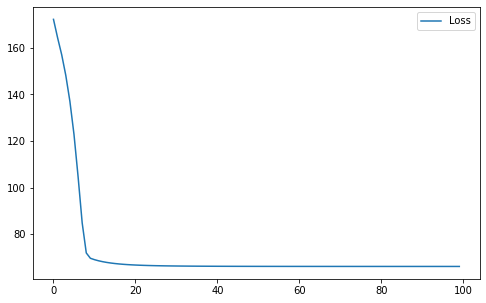

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_, label='Loss')
plt.legend()